libraries

In [ ]:
import subprocess
import os
import json
from glob import glob
import pandas as pd

In [9]:


subprocess.run(
    ["python3", "/Users/tolgasabanoglu/Desktop/github/spatiotemporal/scripts/parse_garmin.py"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
)


CompletedProcess(args=['python3', '/Users/tolgasabanoglu/Desktop/github/spatiotemporal/scripts/parse_garmin.py'], returncode=0)

In [10]:
# Directory with your raw Garmin data
raw_dir = "/Users/tolgasabanoglu/Desktop/github/spatiotemporal/data/raw/"
json_files = sorted(glob(os.path.join(raw_dir, "*.json")))

# Known Garmin data prefixes
file_types = ["steps", "stress", "sleep", "body_battery", "heart_rate"]

audit_rows = []

for ftype in file_types:
    matching = [f for f in json_files if os.path.basename(f).startswith(ftype)]
    entry = {
        "type": ftype,
        "file_count": len(matching),
        "format": "❓",
        "has_date": False,
        "sample_date": "—",
        "top_keys": []
    }
    
    for file in matching:
        try:
            with open(file) as f:
                data = json.load(f)

                if isinstance(data, list) and data:
                    entry["format"] = "list"
                    entry["top_keys"] = list(data[0].keys())
                    date = (
                        data[0].get("calendarDate") or
                        data[0].get("startGMT") or
                        data[0].get("startTimestampGMT")
                    )
                    if date:
                        entry["has_date"] = True
                        entry["sample_date"] = str(date)[:10]
                    break

                elif isinstance(data, dict):
                    entry["format"] = "dict"
                    entry["top_keys"] = list(data.keys())
                    date = (
                        data.get("calendarDate") or
                        data.get("date") or
                        data.get("startTimestampGMT")
                    )
                    if date:
                        entry["has_date"] = True
                        entry["sample_date"] = str(date)[:10]
                    break
        except Exception as e:
            entry["top_keys"] = [f"⚠️ Error: {e}"]

    audit_rows.append(entry)

# Show audit results as table
df_audit = pd.DataFrame(audit_rows)
df_audit = df_audit[["type", "file_count", "format", "has_date", "sample_date", "top_keys"]]

# Print as plain table
print("\n📊 Garmin JSON File Audit:\n")
print(df_audit.to_string(index=False))



📊 Garmin JSON File Audit:

        type  file_count format  has_date sample_date                                                                                                                                                                                                                                                                                                top_keys
       steps         150   list      True  2025-02-24                                                                                                                                                                                                                          [startGMT, endGMT, steps, pushes, primaryActivityLevel, activityLevelConstant]
      stress         150   dict      True  2025-02-25 [userProfilePK, calendarDate, startTimestampGMT, endTimestampGMT, startTimestampLocal, endTimestampLocal, maxStressLevel, avgStressLevel, stressChartValueOffset, stressChartYAxisOrigin, stressValueDescriptorsDTOList, s

In [45]:
import os
import json
import pandas as pd
from glob import glob
from collections import defaultdict

# ---- Setup ----
raw_dir = "/Users/tolgasabanoglu/Desktop/github/spatiotemporal/data/raw/"
json_files = sorted(glob(os.path.join(raw_dir, "*.json")))
summary = defaultdict(dict)

# ---- Parse Files ----
for file in json_files:
    fname = os.path.basename(file)

    try:
        with open(file) as f:
            data = json.load(f)
    except Exception as e:
        print(f"⚠️ Could not load {fname}: {e}")
        continue

    # ---- STEPS ----
    if fname.startswith("steps") and isinstance(data, list) and data:
        date = data[0].get("startGMT", "")[:10]
        steps = sum(item.get("steps", 0) for item in data if isinstance(item, dict))
        summary[date]["steps"] = steps

    # ---- STRESS ----
    elif fname.startswith("stress") and isinstance(data, dict):
        date = data.get("calendarDate")
        if date:
            summary[date]["avg_stress"] = data.get("avgStressLevel")
            summary[date]["max_stress"] = data.get("maxStressLevel")

    # ---- BODY BATTERY ----
    elif fname.startswith("body_battery"):
        if isinstance(data, list):
            for entry in data:
                if isinstance(entry, dict):
                    date = entry.get("date")
                    if date:
                        summary[date]["body_charged"] = entry.get("charged")
                        summary[date]["body_drained"] = entry.get("drained")
        elif isinstance(data, dict):
            date = data.get("date")
            if date:
                summary[date]["body_charged"] = data.get("charged")
                summary[date]["body_drained"] = data.get("drained")

    # ---- HEART RATE ----
    elif fname.startswith("heart_rate") and isinstance(data, dict):
        date = data.get("calendarDate")
        if date:
            summary[date]["resting_hr"] = data.get("restingHeartRate")

    # ---- SLEEP ----
    elif fname.startswith("sleep") and isinstance(data, dict):
        record = {}
        date = None

        daily = data.get("dailySleepDTO")
        if isinstance(daily, dict):
            date = daily.get("calendarDate") or daily.get("sleepEndTimestampGMT", "")[:10]
            record.update({
                "sleep_score": daily.get("overallSleepScore"),
                "total_sleep_s": daily.get("sleepTimeSeconds"),
                "deep_sleep_s": daily.get("deepSleepSeconds"),
                "light_sleep_s": daily.get("lightSleepSeconds"),
                "rem_sleep_s": daily.get("remSleepSeconds"),
                "awake_s": daily.get("awakeSleepSeconds"),
                "restless_moments": daily.get("restlessMomentsCount")
            })

        rem = data.get("remSleepData")
        if isinstance(rem, dict):
            record.update({
                "rem_count": rem.get("remSleepCount"),
                "avg_rem_duration_s": rem.get("avgRemSleepSeconds")
            })

        if date:
            summary[date].update(record)

# ---- Create DataFrame ----
df = pd.DataFrame.from_dict(summary, orient="index").reset_index()
df = df.rename(columns={"index": "date"})
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values("date")

# ---- Convert seconds → hours ----
sleep_cols = ["total_sleep_s", "deep_sleep_s", "light_sleep_s", "rem_sleep_s", "awake_s", "avg_rem_duration_s"]
for col in sleep_cols:
    if col in df.columns:
        df[col.replace("_s", "_h")] = df[col] / 3600

# ---- Preview ----
df


,date,body_charged,body_drained,resting_hr,sleep_score,total_sleep_s,deep_sleep_s,light_sleep_s,rem_sleep_s,awake_s,restless_moments,steps,avg_stress,max_stress,total_hleep_h,deep_hleep_h,light_hleep_h,rem_hleep_h,awake_h
150,2025-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,525.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2025-02-25,0.0,13.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9953.0,54.0,96.0,NaN,NaN,NaN,NaN,NaN
1,2025-02-26,51.0,51.0,64.0,NaN,23340.0,3300.0,14280.0,5760.0,60.0,NaN,2926.0,46.0,97.0,6.483333,0.916667,3.966667,1.600000,0.016667
2,2025-02-27,50.0,23.0,68.0,NaN,31440.0,4380.0,23400.0,3660.0,4680.0,NaN,8521.0,43.0,96.0,8.733333,1.216667,6.500000,1.016667,1.300000
3,2025-02-28,70.0,71.0,59.0,NaN,38985.0,3120.0,23880.0,12000.0,540.0,NaN,17681.0,25.0,99.0,10.829167,0.866667,6.633333,3.333333,0.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2025-07-20,66.0,59.0,60.0,NaN,26940.0,5820.0,15840.0,5280.0,0.0,NaN,5931.0,38.0,99.0,7.483333,1.616667,4.400000,1.466667,0.000000
146,2025-07-21,62.0,61.0,60.0,NaN,28620.0,4740.0,17100.0,6780.0,240.0,NaN,9781.0,38.0,99.0,7.950000,1.316667,4.750000,1.883333,0.066667
147,2025-07-22,24.0,33.0,NaN,NaN,22800.0,1860.0,19800.0,1140.0,2280.0,NaN,6295.0,NaN,NaN,6.333333,0.516667,5.500000,0.316667,0.633333
148,2025-07-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
import pandas as pd
import numpy as np

# Assuming your DataFrame is already loaded as `df`

# Step 1: Drop columns where all values are NaN
df = df.dropna(axis=1, how='all')

# Step 2: Create 'body_battery' = body_charged - body_drained
df['body_battery'] = df['body_charged'] - df['body_drained']

# Step 3: Create 'mean_ndvi' column with random values between -1 and 1
# Lower avg_stress → values closer to 1
# We'll use a normal distribution with mean shifting based on avg_stress
def generate_ndvi(avg_stress):
    if pd.isna(avg_stress):
        return np.random.uniform(-1, 1)

    stress_normalized = np.clip(avg_stress / 100, 0, 1)
    ndvi_bias = 1 - 2 * stress_normalized

    # Reduce scale to tighten correlation
    ndvi = ndvi_bias + np.random.normal(loc=0, scale=0.02)

    # Clamp between -1 and 1
    return np.clip(ndvi, -1, 1)




df['mean_ndvi'] = df['avg_stress'].apply(generate_ndvi)


/var/folders/jg/x92gk5yd0t560nh7hmhyvm040000gn/T/ipykernel_10304/1885346427.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
# Step 1: Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Step 2: Set 'date' as the index
df.set_index('date', inplace=True)

# Step 3: Resample weekly and take the mean
# You can use 'W-MON' to start weeks on Monday, 'W-SUN' for Sunday, or just 'W' (default Sunday)
weekly_df = df.resample('W').mean().reset_index()


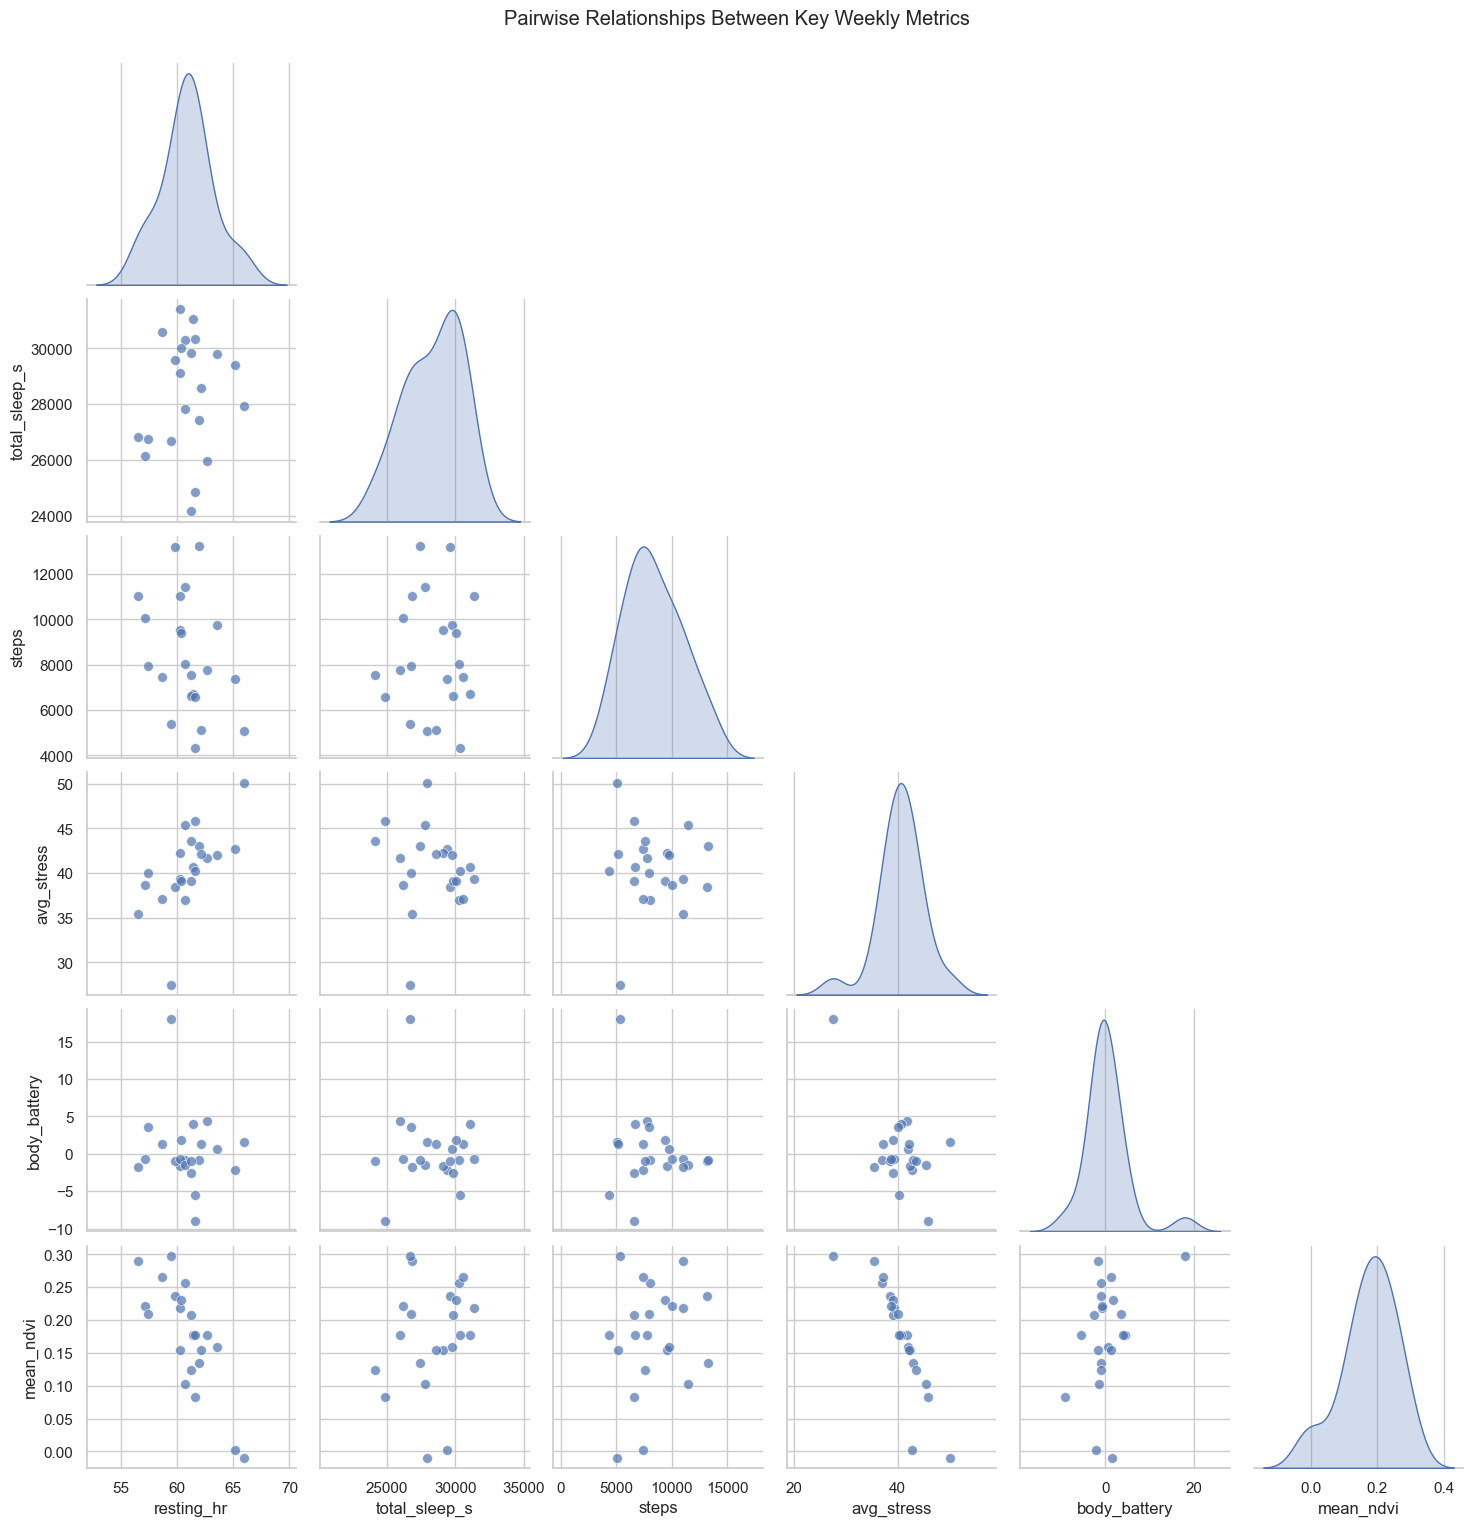

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select your focused columns
focus_cols = ['resting_hr', 'total_sleep_s', 'steps', 'avg_stress', 'body_battery', 'mean_ndvi']
subset_df = weekly_df[focus_cols].dropna()  # Drop rows with NaNs in these columns

# Create the pairplot
sns.pairplot(subset_df, corner=True, diag_kind='kde', plot_kws={'alpha': 0.7, 's': 50})
plt.suptitle("Pairwise Relationships Between Key Weekly Metrics", y=1.02)
plt.show()


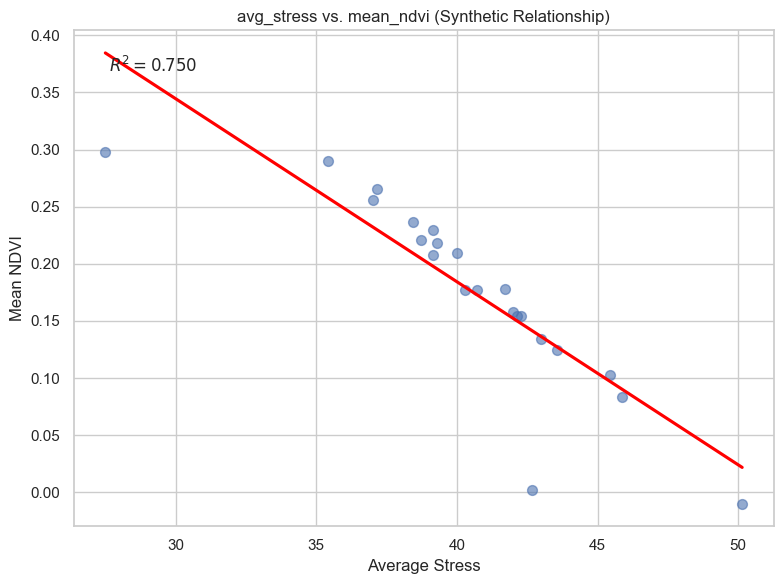

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

sns.set(style="whitegrid")

x = weekly_df['avg_stress'].dropna()
y = weekly_df['mean_ndvi'].dropna()

# Make sure x and y align (drop mismatches)
df_for_reg = weekly_df[['avg_stress', 'mean_ndvi']].dropna()
x = df_for_reg['avg_stress']
y = df_for_reg['mean_ndvi']

# Calculate linear regression and R^2
slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value**2

plt.figure(figsize=(8, 6))
sns.regplot(
    x=x,
    y=y,
    scatter_kws={'alpha': 0.6, 's': 50},
    line_kws={'color': 'red'},
    ci=None
)

# Add R^2 text
plt.text(
    0.05, 0.95,
    f'$R^2 = {r_squared:.3f}$',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)

plt.title("avg_stress vs. mean_ndvi (Synthetic Relationship)")
plt.xlabel("Average Stress")
plt.ylabel("Mean NDVI")
plt.tight_layout()
plt.show()
